In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy.api as sc
# from anndata import read_loom
from anndata import read_h5ad
sc.logging.print_versions()

/home/martin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.3 anndata==0.6.20 umap==0.3.8 numpy==1.16.4 scipy==1.2.1 pandas==0.25.0 scikit-learn==0.21.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
# Data path
data_path = '/data3/martin/tms_gene_data'

In [3]:
# Raw data (one of the previous version which 
# only differ from the official version by annotation)
adata = read_h5ad(f"{data_path}/tabula-muris-senis-facs-reannotated-except-for-marrow-lung-kidney.h5ad")

In [4]:
# Official annotation
df_annotation = pd.read_csv(f"{data_path}/tabula-muris-senis-facs-official-annotations.csv",
                            index_col = 0)
df_annotation = df_annotation.loc[adata.obs.index]

/home/martin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Compare the annotation with the old one
if np.sum((df_annotation.index != adata.obs.index))==0:
    print('new annotation matches with the old\nmerge annotation')
    adata.obs = df_annotation
else:
    print('Annotation does not match')

new annotation matches with the old
merge annotation


In [6]:
adata.obs['cell_ontology_class_old'] = adata.obs['cell_ontology_class']
adata.obs['cell_ontology_class'] = adata.obs['cell_ontology_class_reannotated']
adata.obs['free_annotation_old'] = adata.obs['free_annotation']
adata.obs['free_annotation'] = adata.obs['free_annotation_reannotated']
adata.obs['n_gene'] = (adata.X>0).sum(axis=1)

In [7]:
# Mean depth
print('Mean sequencing depth', adata.X.sum(axis=1).mean())

Mean sequencing depth 843523.7


## QC filtering

In [8]:
# Filter cells and genes
print(adata)
print(f'\n# remove genes expressed in less than 5 cells')
sc.pp.filter_genes(adata, min_cells=5)
print(f'# remove cell expressing less than 500 genes')
sc.pp.filter_cells(adata, min_genes=500)
print(adata)
print('\n# remove cells whose \n\t1. Tissue annotation is nan'
      + '\n\t2. n_counts is smaller than 5000')
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
ind_select = (adata.obs['tissue']!='nan') & (adata.obs['age']!='nan') & \
            (adata.obs['n_counts']>=5000)
adata = adata[ind_select,]
print(adata)

AnnData object with n_obs × n_vars = 164311 × 23341 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'cell_ontology_class_reannotated', 'free_annotation_reannotated', 'cell_ontology_class_old', 'free_annotation_old', 'n_gene'

# remove genes expressed in less than 5 cells
# remove cell expressing less than 500 genes
AnnData object with n_obs × n_vars = 116690 × 22940 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'cell_ontology_class_reannotated', 'free_annotation_reannotated', 'cell_ontology_class_old', 'free_annotation_old', 'n_gene', 'n_genes'
    var: 'n_cells'

# remove cells whose 
	1. Tissue annotation is nan
	2. n_counts is smaller than 5000
View of AnnData object with n_obs × n_vars = 115563 

## Write the data

In [9]:
adata.write(f'{data_path}/facs_filtered.h5ad')

Trying to set attribute `.obs` of view, making a copy.
... storing 'FACS.selection' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'age' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_ontology_class' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_ontology_id' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cellid' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'mouse.id' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'plate' as categorical
Trying to set attribute `.obs` of view, making a copy.

### Sequencing depth for different ages (Supp Figure 1C)

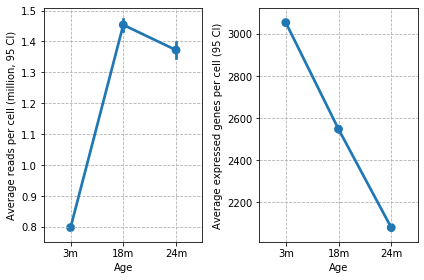

In [11]:
adata.obs['n_counts_mil'] = adata.obs['n_counts']/1e6

plt.figure(figsize=[6,4])

plt.subplot(121)
sns.pointplot(x='age', y='n_counts_mil', data=adata.obs, order=['3m', '18m', '24m'])
plt.ylabel('Average reads per cell (million, 95 CI)')
plt.xlabel('Age')
plt.grid(linestyle='--')

plt.subplot(122)
sns.pointplot(x='age', y='n_gene', data=adata.obs, order=['3m', '18m', '24m'])
plt.ylabel('Average expressed genes per cell (95 CI)')
plt.xlabel('Age')
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig('/home/martin/maca/results/tms_gene_figure'
            + '/qc_depth.pdf', transparent=True)
plt.show()